In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib_venn import venn2, venn3
import os

In [181]:
# Global options

sns.set_style("white")
sns.set(font_scale=2, style="ticks")

height=15
aspect=1
x_jitter=0
y_jitter=0

# xlim=(0,10)
ylim=(-10, 10)
alpha=1
marker='.'
s=1
legend=True
legend_out=False
linewidth=0
x_jitter=0
y_jitter=0
plt.rcParams["figure.figsize"] = (20,20)

In [182]:
def merge_intervals(input_list):
    """
    Given a list of intervals, merge the overlapping ones.
    https://stackoverflow.com/questions/43600878/merging-overlapping-intervals
    """
    # sort interval
    input_list.sort(key=lambda interval: interval[0])
    merged = [input_list[0]]
    for current in input_list:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)
    return merged

In [183]:
annotation_path = "../../00_annotation/results/annotation/canonical_geneset.exons.no_repeat_overlap_and_ce_11_repeats.filtered.merged.gtf"

In [184]:
annotation = pd.read_csv(annotation_path, header=None, sep="\t")
annotation.columns = ["seqname",
                      "source",
                      "feature",
                      "start",
                      "end",
                      "score",
                      "strand",
                      "frame",
                      "attribute"]

In [185]:
annotation = annotation[annotation["feature"] == "exon"]

In [186]:
annotation.head()

,seqname,source,feature,start,end,score,strand,frame,attribute
0,MtDNA,WormBase,exon,1,55,.,+,.,"gene_id ""WBGene00014450""; transcript_id ""MTCE...."
1,MtDNA,WormBase,exon,58,111,.,+,.,"gene_id ""WBGene00014451""; transcript_id ""MTCE...."
2,MtDNA,WormBase,exon,113,549,.,+,.,"gene_id ""WBGene00010957""; transcript_id ""MTCE...."
3,MtDNA,WormBase,exon,549,783,.,+,.,"gene_id ""WBGene00010958""; transcript_id ""MTCE...."
4,MtDNA,WormBase,exon,785,840,.,+,.,"gene_id ""WBGene00014452""; transcript_id ""MTCE...."


In [187]:
annotation["gene_id"] = annotation["attribute"].str.split(";").str[0].str.replace("gene_id ", "").str.replace("\"", "")

In [188]:
annotation_short = annotation[["seqname", "start", "end", "score", "gene_id", "strand"]].copy()

In [189]:
annotation_short.head()

,seqname,start,end,score,gene_id,strand
0,MtDNA,1,55,.,WBGene00014450,+
1,MtDNA,58,111,.,WBGene00014451,+
2,MtDNA,113,549,.,WBGene00010957,+
3,MtDNA,549,783,.,WBGene00010958,+
4,MtDNA,785,840,.,WBGene00014452,+


In [190]:
annotation_short["start"] = annotation_short["start"] - 1

In [191]:
annotation_short.head()

,seqname,start,end,score,gene_id,strand
0,MtDNA,0,55,.,WBGene00014450,+
1,MtDNA,57,111,.,WBGene00014451,+
2,MtDNA,112,549,.,WBGene00010957,+
3,MtDNA,548,783,.,WBGene00010958,+
4,MtDNA,784,840,.,WBGene00014452,+


In [192]:
w = open("union_exons.bed", 'w')
for gene_group in annotation_short.groupby("gene_id"):
    seqname, score, gene_id, strand = gene_group[1].iloc[0][["seqname", "score", "gene_id", "strand"]]
    intervals = merge_intervals(gene_group[1][(["start", "end"])].values.tolist())
    for interval in intervals:
        w.write("\t".join([str(seqname), str(interval[0]), str(interval[1]), str(score), gene_id, strand + os.linesep]))
w.close()

In [193]:
union_bed = pd.read_csv("union_exons.bed", header=None, sep="\t")
union_bed.columns = ["chrom", "start", "end", "score", "gene_id", "strand"]
union_bed["length"] = union_bed["end"] - union_bed["start"]

In [194]:
gene_length = union_bed.groupby("gene_id")["length"].sum().reset_index()
gene_length.columns = ["Name", "length"]

In [195]:
gene_length.head()

,Name,length
0,I:10005952-10006427:+,476
1,I:10006437-10006683:+,247
2,I:1001335-1001573:-,239
3,I:10015772-10015842:+,71
4,I:1002040-1002265:-,226


In [196]:
gene_length.shape

(101577, 2)

In [197]:
counts = pd.read_csv("../../03_WAGO_IPs/results/counts/1_alignment_per_read_reverse/counts.tsv",
                     header=0,
                     sep="\t")

In [198]:
counts.shape

(75398, 43)

In [199]:
counts.tail()

,Name,counts_Input_WAGO-1_A,counts_Input_WAGO-1_B,counts_Input_WAGO-1_C,counts_Input_WAGO-1_dpf-3_null_A,counts_Input_WAGO-1_dpf-3_null_B,counts_Input_WAGO-1_dpf-3_null_C,counts_Input_WAGO-1_P3G_A,counts_Input_WAGO-1_P3G_B,counts_Input_WAGO-1_P3G_C,...,counts_IP_WAGO-3_C,counts_IP_WAGO-3_dpf-3_null_A,counts_IP_WAGO-3_dpf-3_null_B,counts_IP_WAGO-3_dpf-3_null_C,counts_IP_WAGO-4_A,counts_IP_WAGO-4_B,counts_IP_WAGO-4_C,counts_IP_WAGO-4_dpf-3_null_A,counts_IP_WAGO-4_dpf-3_null_B,counts_IP_WAGO-4_dpf-3_null_C
75393,__no_feature,689087,1346741,875613,541705,409289,484532,518735,997075,758504,...,1186841,497243,359099,262083,225256,279635,233270,73241,125469,137139
75394,__ambiguous,560,1257,853,240,187,230,457,947,519,...,5646,1961,1417,922,686,945,769,48,97,112
75395,__too_low_aQual,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75396,__not_aligned,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75397,__alignment_not_unique,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
df = pd.merge(gene_length, counts, on="Name")

In [201]:
df.head()

,Name,length,counts_Input_WAGO-1_A,counts_Input_WAGO-1_B,counts_Input_WAGO-1_C,counts_Input_WAGO-1_dpf-3_null_A,counts_Input_WAGO-1_dpf-3_null_B,counts_Input_WAGO-1_dpf-3_null_C,counts_Input_WAGO-1_P3G_A,counts_Input_WAGO-1_P3G_B,...,counts_IP_WAGO-3_C,counts_IP_WAGO-3_dpf-3_null_A,counts_IP_WAGO-3_dpf-3_null_B,counts_IP_WAGO-3_dpf-3_null_C,counts_IP_WAGO-4_A,counts_IP_WAGO-4_B,counts_IP_WAGO-4_C,counts_IP_WAGO-4_dpf-3_null_A,counts_IP_WAGO-4_dpf-3_null_B,counts_IP_WAGO-4_dpf-3_null_C
0,I:10005952-10006427:+,476,0,0,0,0,0,0,1,0,...,2,1,0,1,0,0,0,0,0,0
1,I:10006437-10006683:+,247,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,I:1001335-1001573:-,239,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,I:10015772-10015842:+,71,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,I:1002040-1002265:-,226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [202]:
df.shape

(75393, 44)

In [203]:
for i in df.iloc[:,2:].values:
    print(len(i))
    break

42


In [204]:
df.columns

Index(['Name', 'length', 'counts_Input_WAGO-1_A', 'counts_Input_WAGO-1_B',
       'counts_Input_WAGO-1_C', 'counts_Input_WAGO-1_dpf-3_null_A',
       'counts_Input_WAGO-1_dpf-3_null_B', 'counts_Input_WAGO-1_dpf-3_null_C',
       'counts_Input_WAGO-1_P3G_A', 'counts_Input_WAGO-1_P3G_B',
       'counts_Input_WAGO-1_P3G_C', 'counts_Input_WAGO-3_A',
       'counts_Input_WAGO-3_B', 'counts_Input_WAGO-3_C',
       'counts_Input_WAGO-3_dpf-3_null_A', 'counts_Input_WAGO-3_dpf-3_null_B',
       'counts_Input_WAGO-3_dpf-3_null_C', 'counts_Input_WAGO-4_A',
       'counts_Input_WAGO-4_B', 'counts_Input_WAGO-4_C',
       'counts_Input_WAGO-4_dpf-3_null_A', 'counts_Input_WAGO-4_dpf-3_null_B',
       'counts_Input_WAGO-4_dpf-3_null_C', 'counts_IP_WAGO-1_A',
       'counts_IP_WAGO-1_B', 'counts_IP_WAGO-1_C',
       'counts_IP_WAGO-1_dpf-3_null_A', 'counts_IP_WAGO-1_dpf-3_null_B',
       'counts_IP_WAGO-1_dpf-3_null_C', 'counts_IP_WAGO-1_P3G_A',
       'counts_IP_WAGO-1_P3G_B', 'counts_IP_WAGO-1_P3G_C'

In [27]:
df_short = df[["Name", 
              "length", 
              "counts_IP_WAGO-1_A", 
              "counts_IP_WAGO-1_B", 
              "counts_IP_WAGO-1_C",
              "counts_IP_WAGO-1_dpf-3_null_A",
              "counts_IP_WAGO-1_dpf-3_null_B",
              "counts_IP_WAGO-1_dpf-3_null_C"
             ]].copy()

In [28]:
df_short = df_short[df_short.iloc[:,2:].sum(axis=1)>10]

In [29]:
# add pseudocount
df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1

In [30]:
sample_reads = df_short.iloc[:,2:].copy()
gene_len = df_short.loc[:, ['length']]
rate = sample_reads.values / gene_len.values
tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)

In [31]:
new_columns = []
for name in list(tpm.columns):
    new_columns.append(name.replace("counts_",""))

In [32]:
tpm.columns = new_columns

In [33]:
tpm.head()

,IP_WAGO-1_A,IP_WAGO-1_B,IP_WAGO-1_C,IP_WAGO-1_dpf-3_null_A,IP_WAGO-1_dpf-3_null_B,IP_WAGO-1_dpf-3_null_C
Name,,,,,,
I:10005952-10006427:+,1.275143,1.065907,0.710665,0.332233,2.221464,2.446186
I:1006641-1006864:+,1.354839,2.265052,3.775407,2.823976,1.888245,2.227777
I:1009907-1010144:-,5.100571,1.421209,2.131995,1.993395,1.777171,4.193462
I:1012042-1012183:+,2.137211,1.191013,1.191114,6.682085,7.446599,3.514239
I:10128135-10128392:+,8.234061,6.555190,7.211321,4.903649,10.656141,5.802581


In [34]:
tpm = np.log2(tpm)

In [35]:
tpm["mean_IP_WAGO-1"] = tpm[["IP_WAGO-1_A", "IP_WAGO-1_B", "IP_WAGO-1_C"]].mean(axis=1)
tpm["mean_IP_WAGO-1_dpf-3_null"] = tpm[["IP_WAGO-1_dpf-3_null_A", "IP_WAGO-1_dpf-3_null_B", "IP_WAGO-1_dpf-3_null_C"]].mean(axis=1)

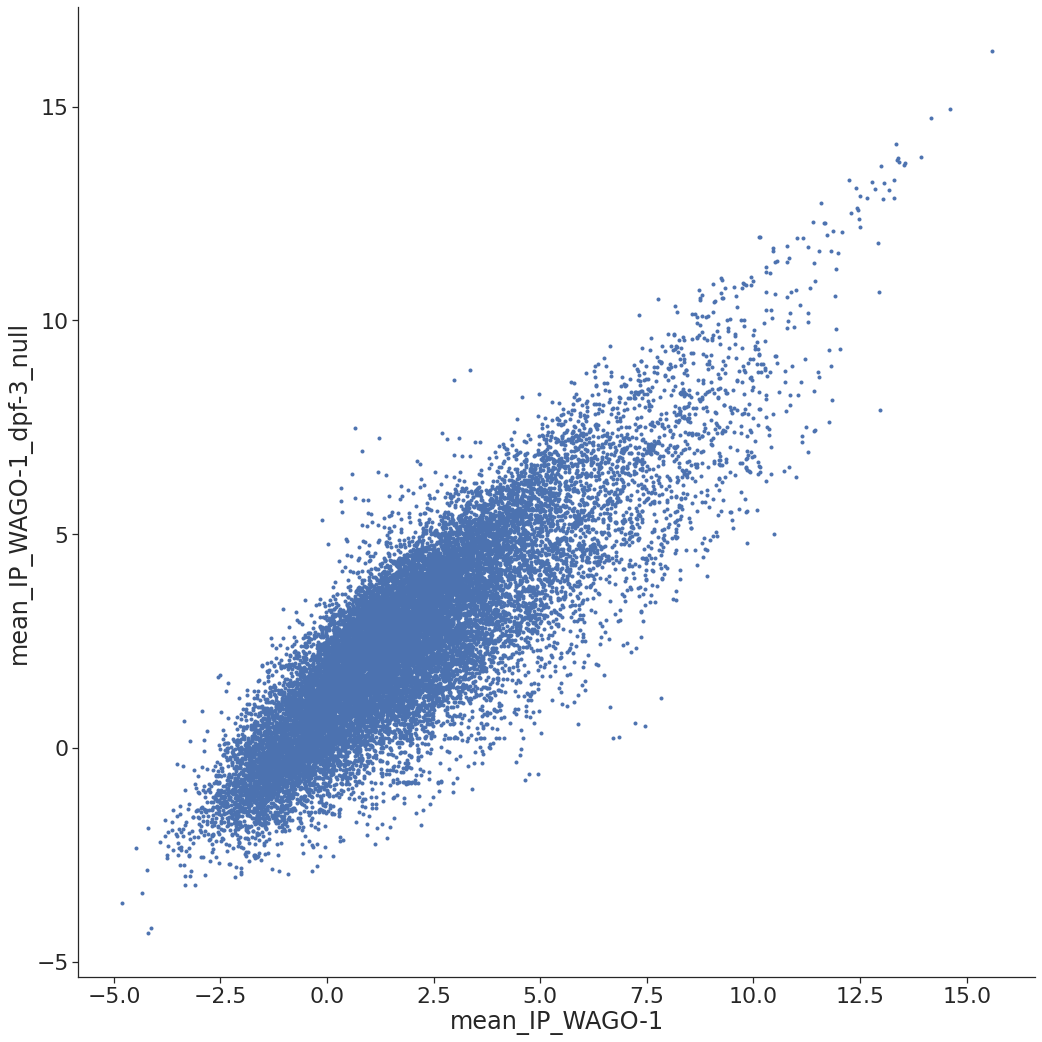

In [36]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

# read table of DE WAGO-1 IP vs WAGO-1 dpf-3 null

In [37]:
df_wago1_wago1_dpf3 = pd.read_csv("../../03_WAGO_IPs/results/filter/DE_htseq_count__1_alignment_per_read__reverse__IP_WAGO-1_dpf-3_null__IP_WAGO-1/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                 header=0,
                 sep="\t")

In [38]:
tpm["sig_wago1_wago1_dpf3null"] = "No"
tpm.loc[tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["logFC"]>0]["id"])), "sig_wago1_wago1_dpf3null"] = "FDR<0.05\nlogFC<0"
tpm.loc[tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["logFC"]<0]["id"])), "sig_wago1_wago1_dpf3null"] = "FDR<0.05\nlogFC>0"

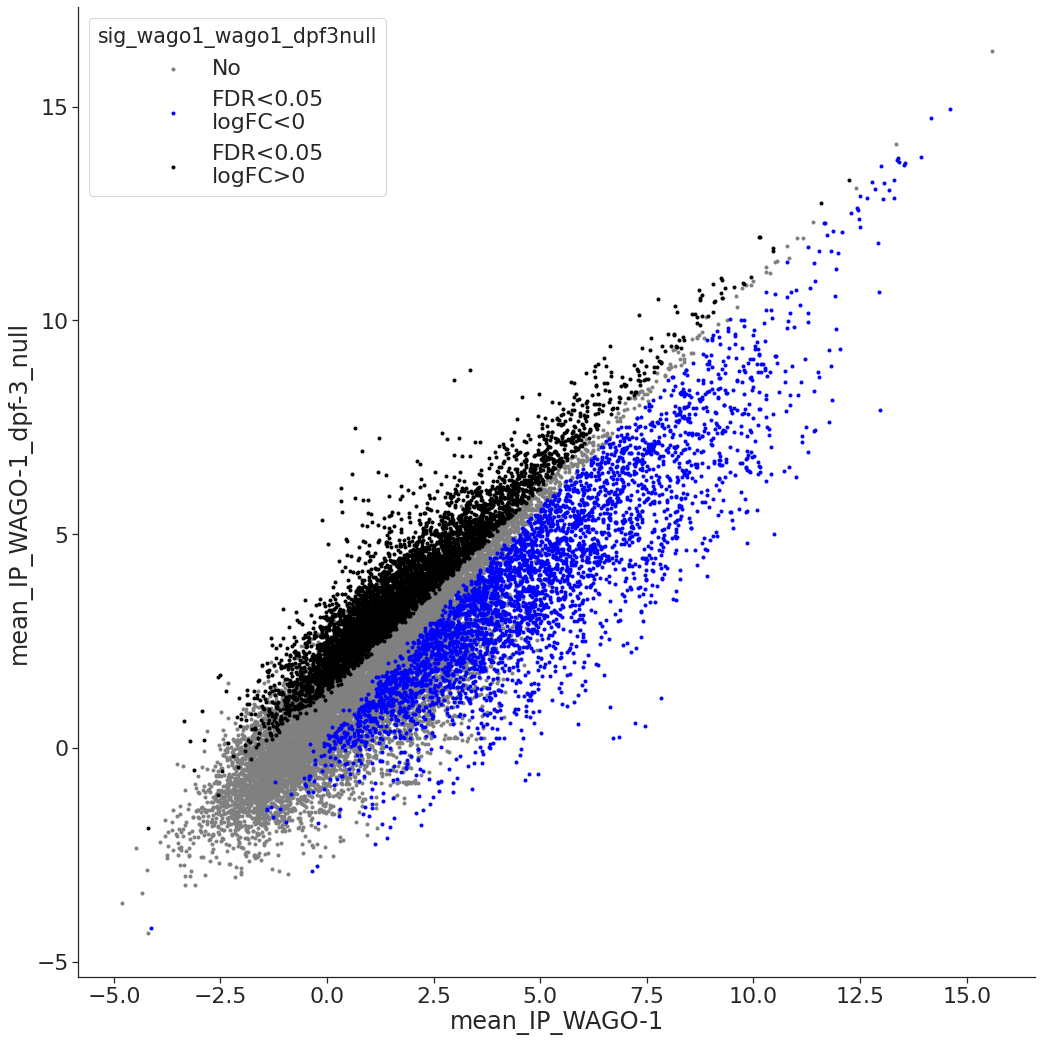

In [39]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_wago1_wago1_dpf3null",
                      hue_order=["No", "FDR<0.05\nlogFC<0", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

# read table of DE dpf-3 null over WT

In [40]:
df_dpf_3_null__over_wt = pd.read_csv("../../01_small_RNA_seq_15_C/results/filter/DE_htseq_count__1_alignment_per_read__reverse__WT__Dpf_3_null/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                 header=0,
                 sep="\t")

In [41]:
tpm["sig_dpf_3_null__over_wt"] = "No"
tpm.loc[tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["logFC"]>0]["id"])), "sig_dpf_3_null__over_wt"] = "FDR<0.05\nlogFC>0"
tpm.loc[tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["logFC"]<0]["id"])), "sig_dpf_3_null__over_wt"] = "FDR<0.05\nlogFC<0"

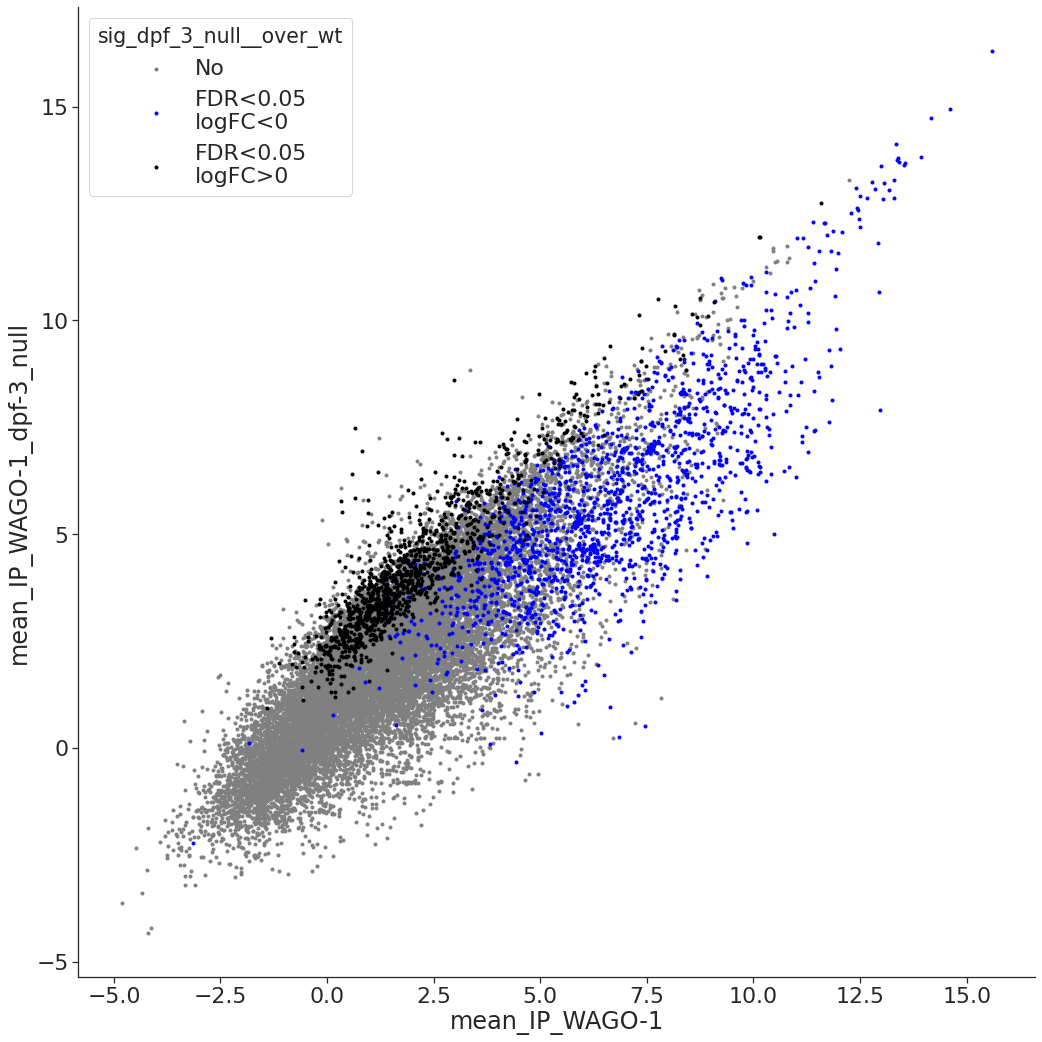

In [42]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_dpf_3_null__over_wt",
                      hue_order=["No", "FDR<0.05\nlogFC<0", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

In [43]:
pd.DataFrame(tpm[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0"].index).to_csv("sig_wago1_wago1_dpf3null_down.tsv", header=None, index=False)

In [44]:
pd.DataFrame(tpm[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0"].index).to_csv("sig_wago1_wago1_dpf3null_up.tsv", header=None, index=False)

In [45]:
pd.DataFrame(tpm[tpm["sig_dpf_3_null__over_wt"] == "FDR<0.05\nlogFC<0"].index).to_csv("sig_dpf_3_null__over_wt_down.tsv", header=None, index=False)

In [46]:
pd.DataFrame(tpm[tpm["sig_dpf_3_null__over_wt"] == "FDR<0.05\nlogFC>0"].index).to_csv("sig_dpf_3_null__over_wt_up.tsv", header=None, index=False)

In [47]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago-1 dpf-3 null specific"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0", "Significant"] = "wago-1 specific"

No                            11615
wago-1 dpf-3 null specific     5359
wago-1 specific                3973
Name: Significant, dtype: int64

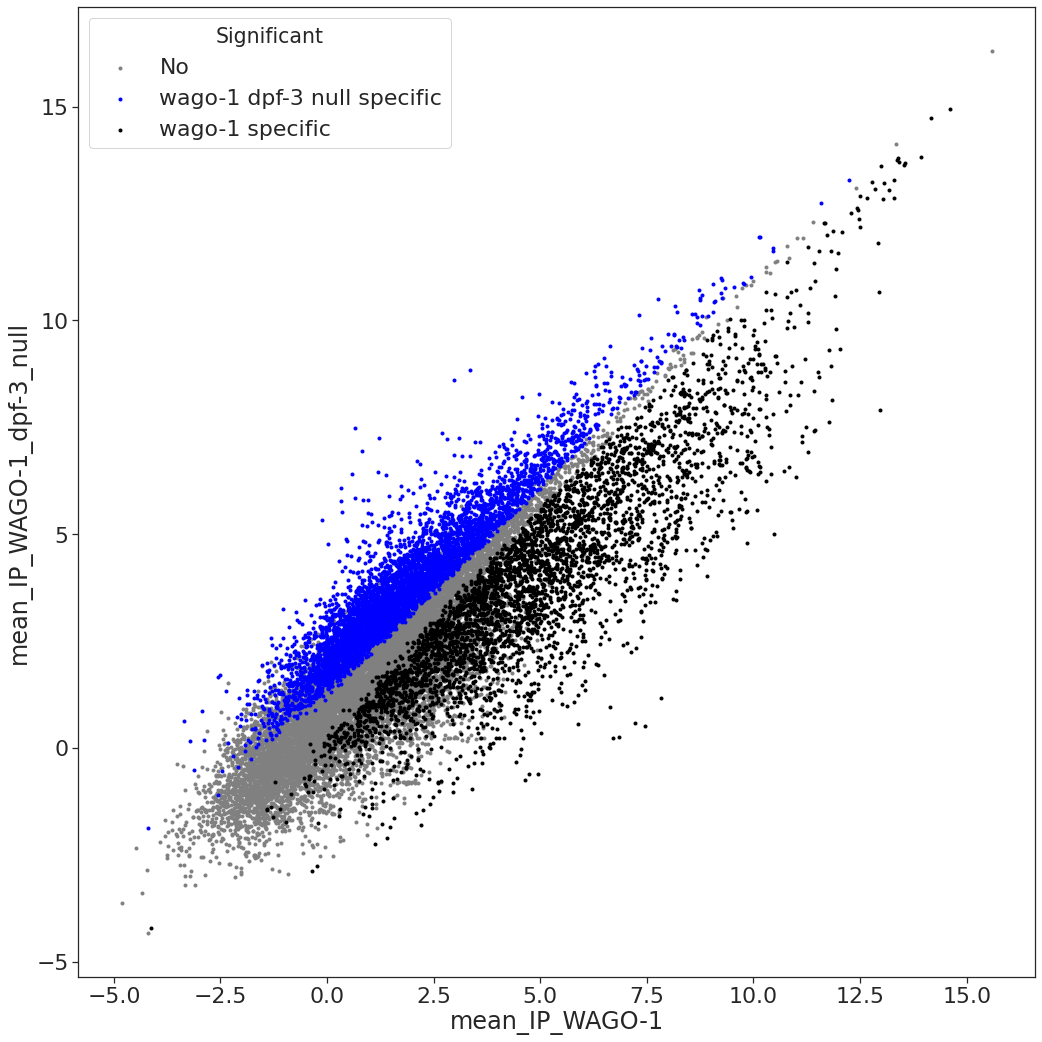

In [48]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
#                       col="annotation",
                      hue_order=["No", "wago-1 dpf-3 null specific", "wago-1 specific"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null.pdf")

tpm["Significant"].value_counts()

In [49]:
tpm.loc[tpm["sig_dpf_3_null__over_wt"] == "FDR<0.05\nlogFC<0", "Significant"] = "dpf_3_null over wt downregulated"

No                                  11458
wago-1 dpf-3 null specific           5245
wago-1 specific                      2642
dpf_3_null over wt downregulated     1602
Name: Significant, dtype: int64

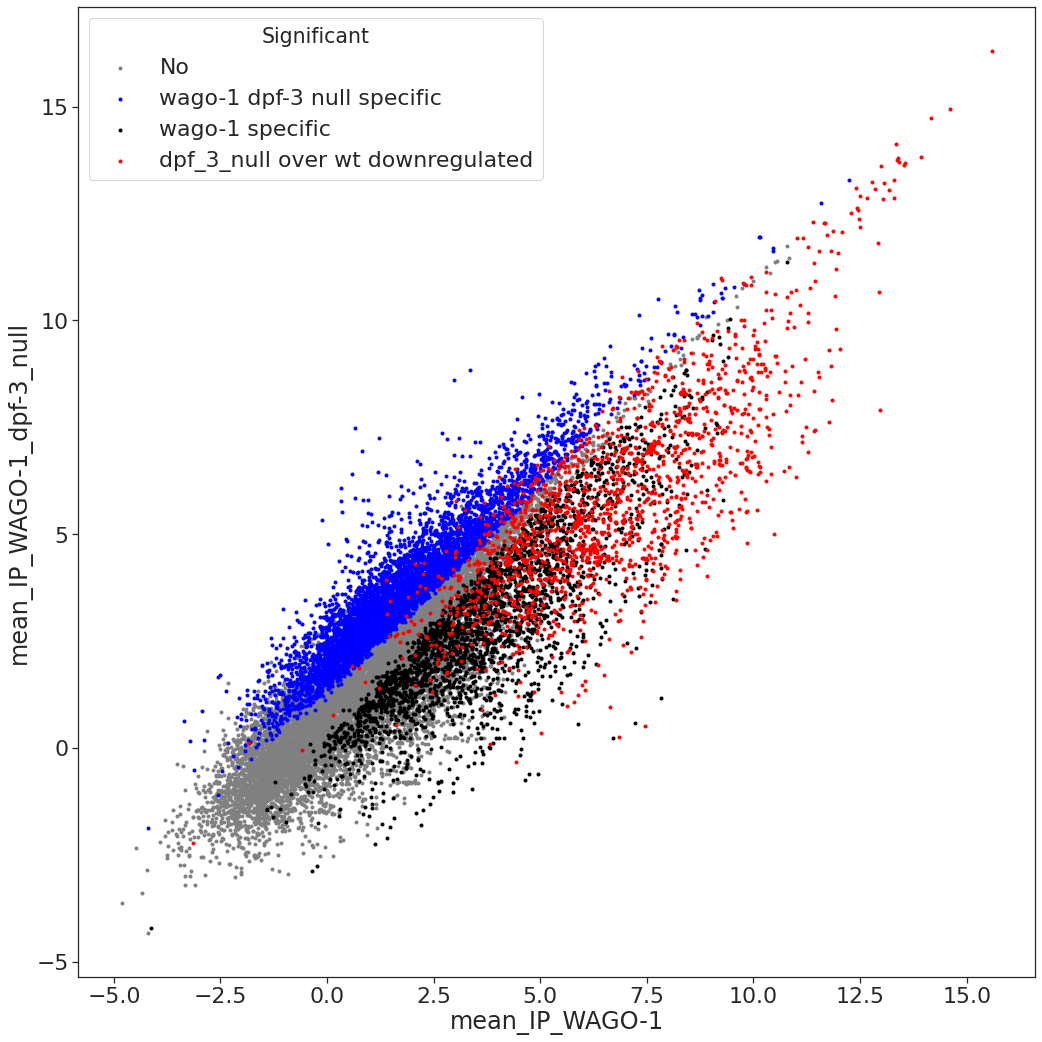

In [50]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
#                       col="annotation",
                      hue_order=["No", "wago-1 dpf-3 null specific", "wago-1 specific", "dpf_3_null over wt downregulated"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null_mark.pdf")

tpm["Significant"].value_counts()

# read table of csr-1 IP over input

In [51]:
df_csr_1_IP_over_input = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__HW3115_INPUT__HW3115_IP/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                                     header=0,
                                     sep="\t")

In [52]:
tpm["Significant"] = "No"
tpm.loc[tpm.index.isin(df_csr_1_IP_over_input[(df_csr_1_IP_over_input["FDR"]<0.05) & (df_csr_1_IP_over_input["logFC"]>0)]["id"].values.tolist()), "Significant"] = "csr-1 bound"

No             16286
csr-1 bound     4661
Name: Significant, dtype: int64

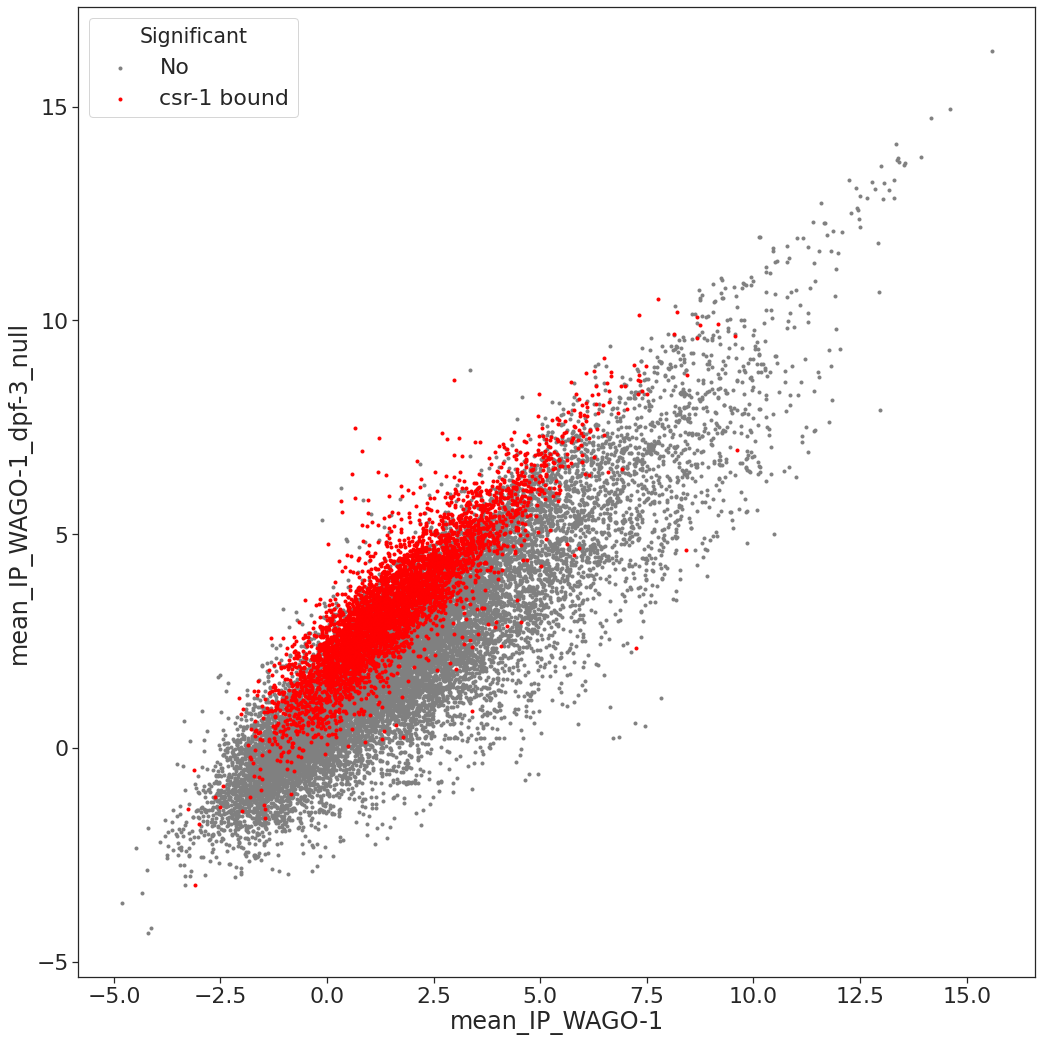

In [53]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "csr-1 bound"],
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null__mark_csr-1_bound.pdf")

tpm["Significant"].value_counts()

In [54]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago-1 dpf-3 null specific"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0", "Significant"] = "wago-1 specific"
tpm.loc[tpm.index.isin(df_csr_1_IP_over_input[(df_csr_1_IP_over_input["FDR"]<0.05) & (df_csr_1_IP_over_input["logFC"]>0)]["id"].values.tolist()), "Significant"] = "csr-1 bound"

No                            10472
csr-1 bound                    4661
wago-1 specific                3839
wago-1 dpf-3 null specific     1975
Name: Significant, dtype: int64

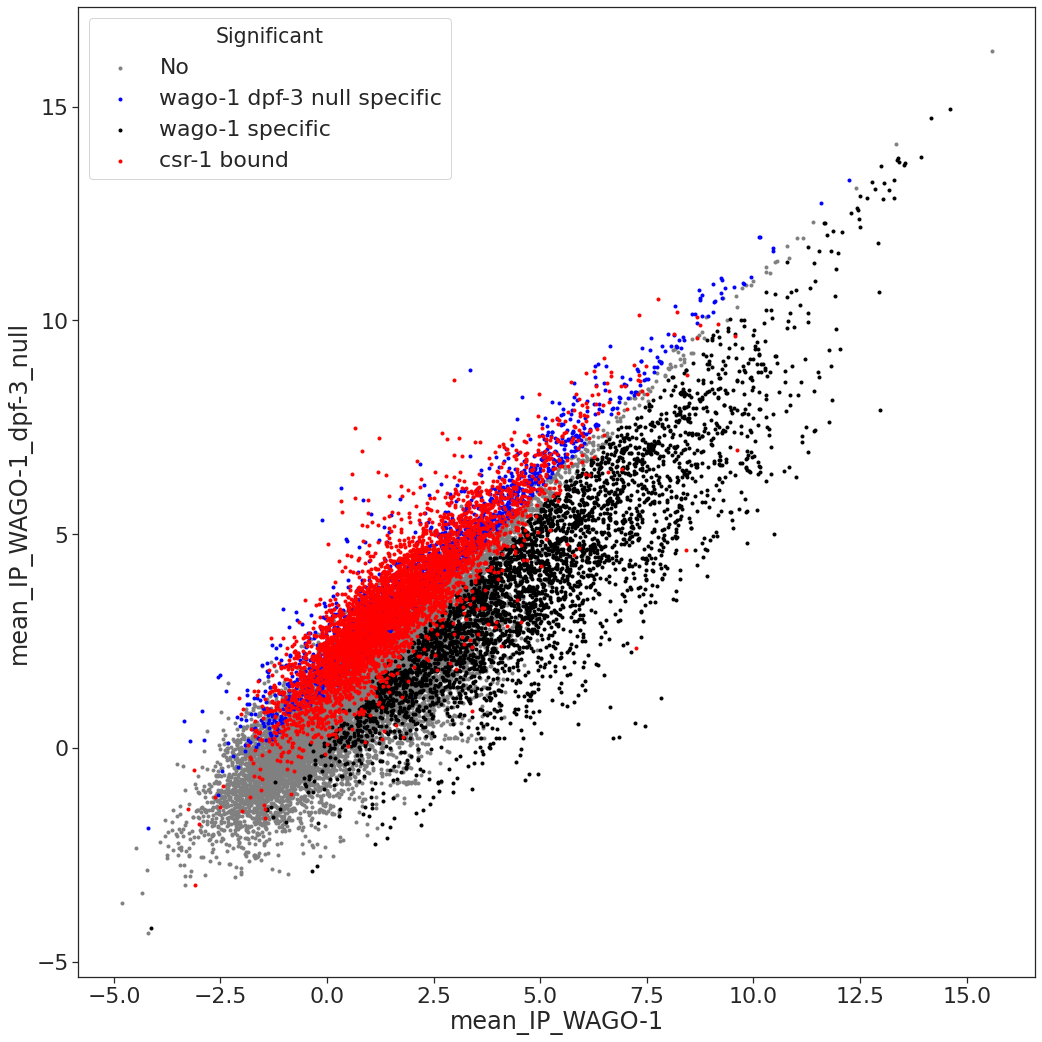

In [55]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "wago-1 dpf-3 null specific", "wago-1 specific", "csr-1 bound"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null__mark_significant_and_csr-1_bound.pdf")

tpm["Significant"].value_counts()

In [56]:
wago_1_dpf_3_null_specific = set(list(tpm[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0"].index.values))

In [57]:
wago_1_specific= set(list(tpm[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0"].index.values))

In [58]:
rest = set(list(tpm[(tpm["sig_wago1_wago1_dpf3null"] != "FDR<0.05\nlogFC<0") & (tpm["sig_wago1_wago1_dpf3null"] != "FDR<0.05\nlogFC>0")].index.values))

In [59]:
csr_1 = set(df_csr_1_IP_over_input[(df_csr_1_IP_over_input["FDR"]<0.05) & (df_csr_1_IP_over_input["logFC"]>0)]["id"].values.tolist())

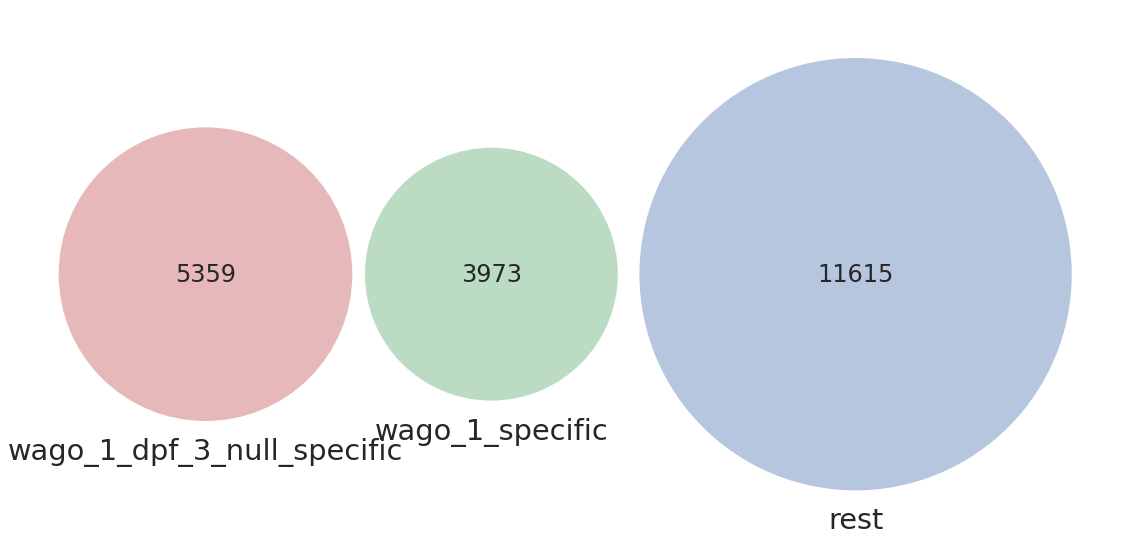

In [60]:
plt.figure(figsize=(20,20))
venn3([wago_1_dpf_3_null_specific, wago_1_specific, rest], ['wago_1_dpf_3_null_specific', 'wago_1_specific', 'rest'])

In [61]:
len(csr_1)

4672

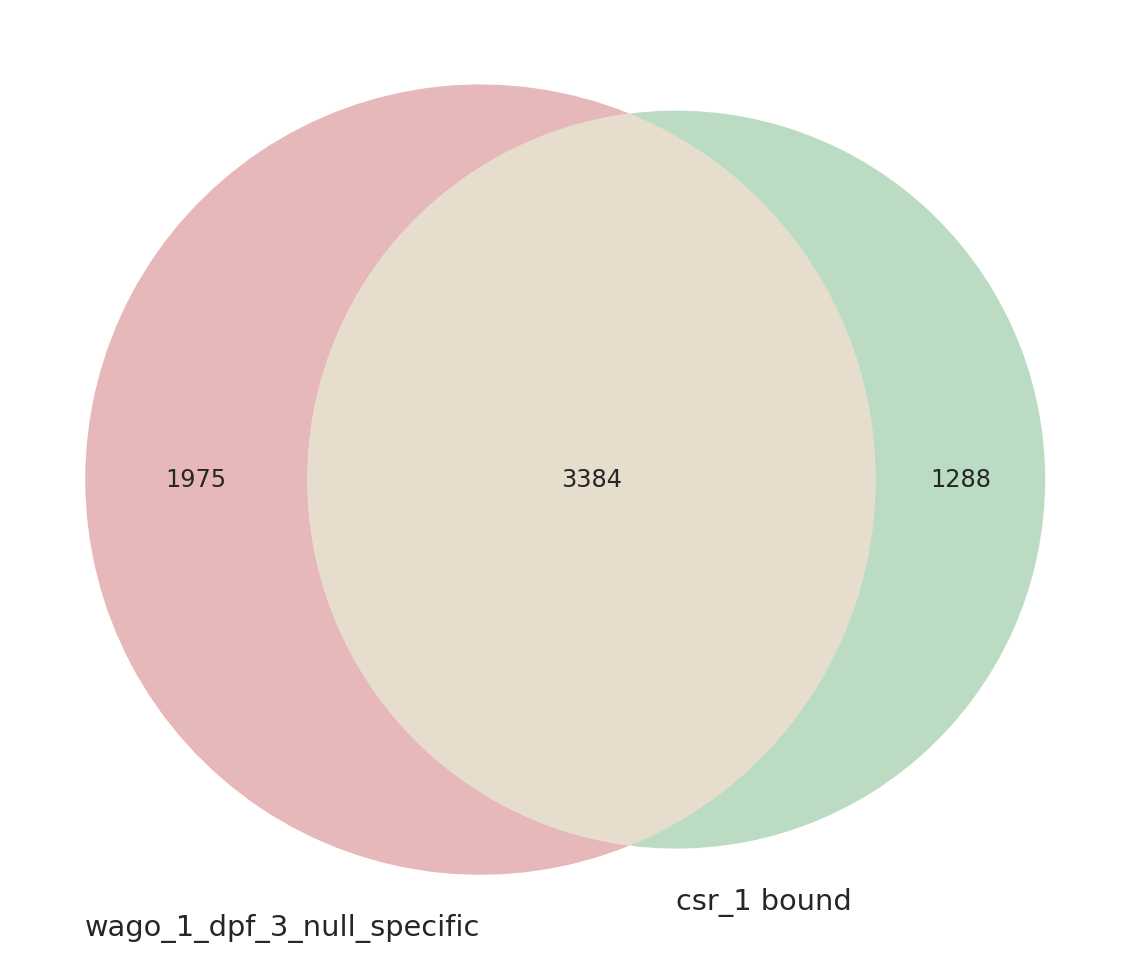

In [62]:
plt.figure(figsize=(20,20))
venn2([wago_1_dpf_3_null_specific, csr_1], ['wago_1_dpf_3_null_specific', 'csr_1 bound'])
plt.savefig("venn__wago_1_dpf_3_null_specific__csr_1_bound.pdf")

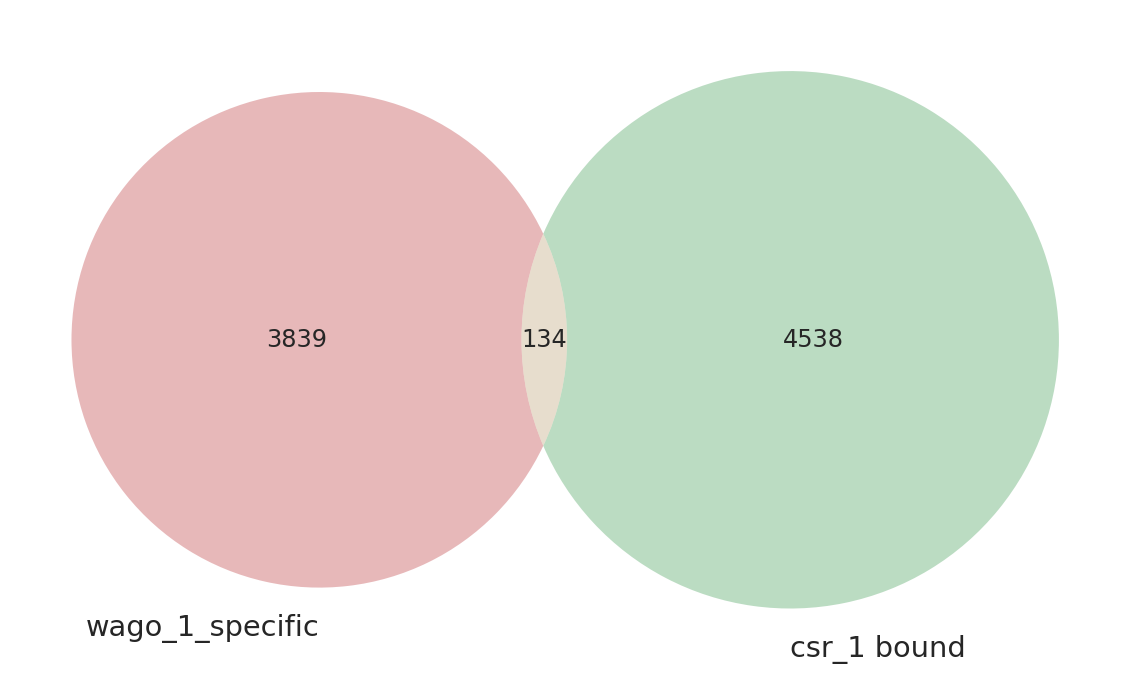

In [63]:
plt.figure(figsize=(20,20))
venn2([wago_1_specific, csr_1], ['wago_1_specific', 'csr_1 bound'])
plt.savefig("venn__wago_1_specific__csr_1_bound.pdf")

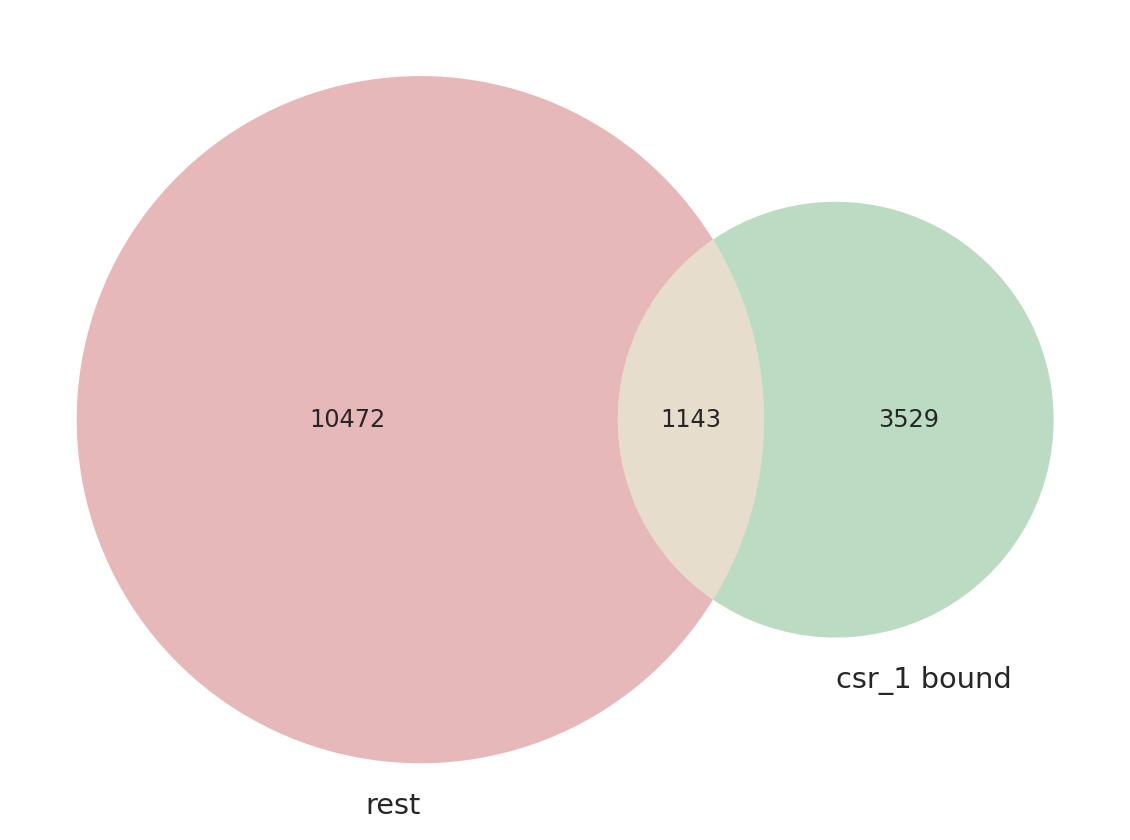

In [64]:
plt.figure(figsize=(20,20))
venn2([rest, csr_1], ['rest', 'csr_1 bound'])
plt.savefig("venn__rest__csr_1_bound.pdf")

In [65]:
wago_1_specific_and_rest = set(list(wago_1_specific) + list(rest))

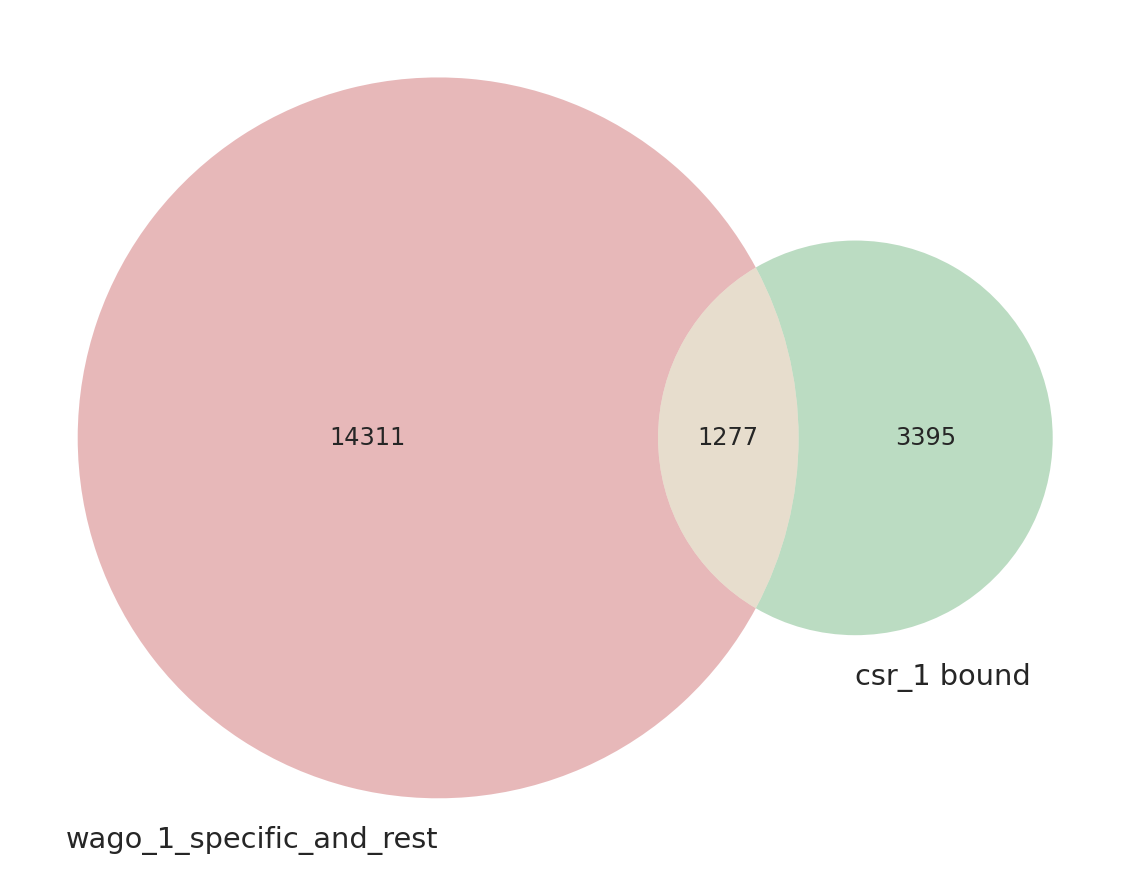

In [66]:
plt.figure(figsize=(20,20))
venn2([wago_1_specific_and_rest, csr_1], ['wago_1_specific_and_rest', 'csr_1 bound'])
plt.savefig("venn__wago_1_specific_and_rest__csr_1_bound.pdf")

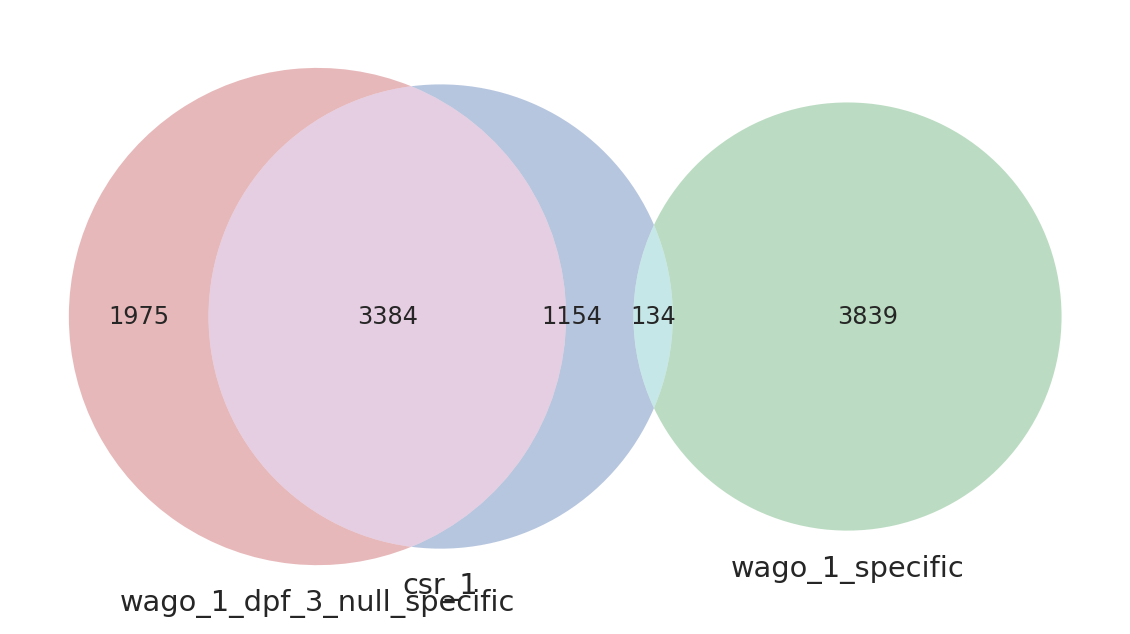

In [67]:
plt.figure(figsize=(20,20))
venn3([wago_1_dpf_3_null_specific, wago_1_specific, csr_1], ['wago_1_dpf_3_null_specific', 'wago_1_specific', 'csr_1'])

In [68]:
len(wago_1_dpf_3_null_specific)

5359

In [69]:
len(wago_1_specific)

3973

In [70]:
len(csr_1)

4672

In [71]:
w = open("FOR_TEA_wago_1_dpf_3_null_specific.tsv", 'w')
for i in wago_1_dpf_3_null_specific:
    w.write(i+'\n')
w.close()

In [72]:
w = open("FOR_TEA_wago_1_specific.tsv", 'w')
for i in wago_1_specific:
    w.write(i+'\n')
w.close()

In [73]:
w = open("FOR_TEA_csr_1_specific.tsv", 'w')
for i in csr_1:
    w.write(i+'\n')
w.close()

# Histone genes

In [74]:
gene_info_path = "/tungstenfs/groups/gbioinfo/DB/WormBase/WS270/c_elegans.PRJNA13758.WS270.geneIDs.txt"

In [75]:
gene_info = pd.read_csv(gene_info_path, header=None, sep=",")

In [76]:
gene_info.fillna("?", inplace=True)

In [77]:
histone_genes = gene_info[gene_info[2].str.startswith("his")][1].values.tolist()

In [78]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago-1 dpf-3 null specific"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0", "Significant"] = "wago-1 specific"
tpm.loc[tpm.index.isin(histone_genes), "Significant"] = "histone"

No                            11582
wago-1 dpf-3 null specific     5344
wago-1 specific                3949
histone                          72
Name: Significant, dtype: int64

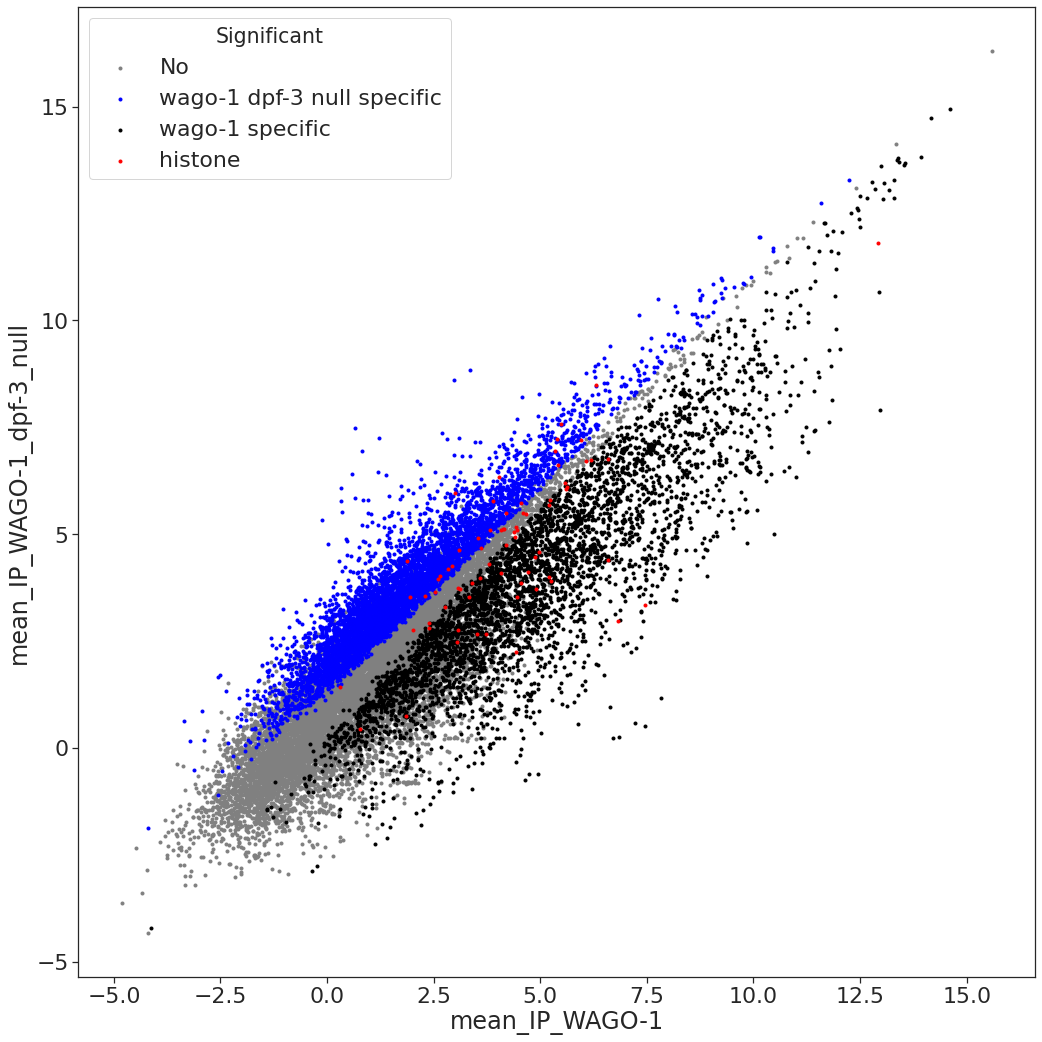

In [79]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "wago-1 dpf-3 null specific", "wago-1 specific", "histone"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null__mark_significant_and_histones.pdf")

tpm["Significant"].value_counts()

# Correlation WAGO-1 IP over WAGO-1 Input (Mark csr-1 bound)

In [80]:
df.columns

Index(['Name', 'length', 'counts_Input_WAGO-1_A', 'counts_Input_WAGO-1_B',
       'counts_Input_WAGO-1_C', 'counts_Input_WAGO-1_dpf-3_null_A',
       'counts_Input_WAGO-1_dpf-3_null_B', 'counts_Input_WAGO-1_dpf-3_null_C',
       'counts_Input_WAGO-1_P3G_A', 'counts_Input_WAGO-1_P3G_B',
       'counts_Input_WAGO-1_P3G_C', 'counts_Input_WAGO-3_A',
       'counts_Input_WAGO-3_B', 'counts_Input_WAGO-3_C',
       'counts_Input_WAGO-3_dpf-3_null_A', 'counts_Input_WAGO-3_dpf-3_null_B',
       'counts_Input_WAGO-3_dpf-3_null_C', 'counts_Input_WAGO-4_A',
       'counts_Input_WAGO-4_B', 'counts_Input_WAGO-4_C',
       'counts_Input_WAGO-4_dpf-3_null_A', 'counts_Input_WAGO-4_dpf-3_null_B',
       'counts_Input_WAGO-4_dpf-3_null_C', 'counts_IP_WAGO-1_A',
       'counts_IP_WAGO-1_B', 'counts_IP_WAGO-1_C',
       'counts_IP_WAGO-1_dpf-3_null_A', 'counts_IP_WAGO-1_dpf-3_null_B',
       'counts_IP_WAGO-1_dpf-3_null_C', 'counts_IP_WAGO-1_P3G_A',
       'counts_IP_WAGO-1_P3G_B', 'counts_IP_WAGO-1_P3G_C'

In [81]:
df_short = df[["Name", 
              "length", 
              "counts_IP_WAGO-1_A", 
              "counts_IP_WAGO-1_B", 
              "counts_IP_WAGO-1_C",
              "counts_Input_WAGO-1_A",
              "counts_Input_WAGO-1_B",
              "counts_Input_WAGO-1_C"
             ]].copy()

In [82]:
df_short = df_short[df_short.iloc[:,2:].sum(axis=1)>10]

In [83]:
# add pseudocount
df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1

In [84]:
sample_reads = df_short.iloc[:,2:].copy()
gene_len = df_short.loc[:, ['length']]
rate = sample_reads.values / gene_len.values
tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)

In [85]:
new_columns = []
for name in list(tpm.columns):
    new_columns.append(name.replace("counts_",""))

In [86]:
tpm.columns = new_columns

In [87]:
tpm.head()

,IP_WAGO-1_A,IP_WAGO-1_B,IP_WAGO-1_C,Input_WAGO-1_A,Input_WAGO-1_B,Input_WAGO-1_C
Name,,,,,,
I:10128135-10128392:+,8.319360,6.612373,7.279101,30.324862,6.635558,9.394805
I:10137068-10137842:+,1.186947,3.962304,2.202942,10.095244,8.835995,12.510243
I:10140918-10141424:-,3.628732,1.345950,2.693933,15.431586,3.376675,9.561576
I:10201789-10202085:+,6.194502,9.764938,8.622627,13.171405,5.764222,8.161143
I:10238747-10239295:+,251.334309,249.217793,234.167924,171.012334,190.219342,128.036299


In [88]:
tpm = np.log2(tpm)

In [89]:
tpm["mean_IP_WAGO-1"] = tpm[["IP_WAGO-1_A", 
                             "IP_WAGO-1_B", 
                             "IP_WAGO-1_C"]].mean(axis=1)

tpm["mean_Input_WAGO-1"] = tpm[["Input_WAGO-1_A", 
                                "Input_WAGO-1_B", 
                                "Input_WAGO-1_C"]].mean(axis=1)

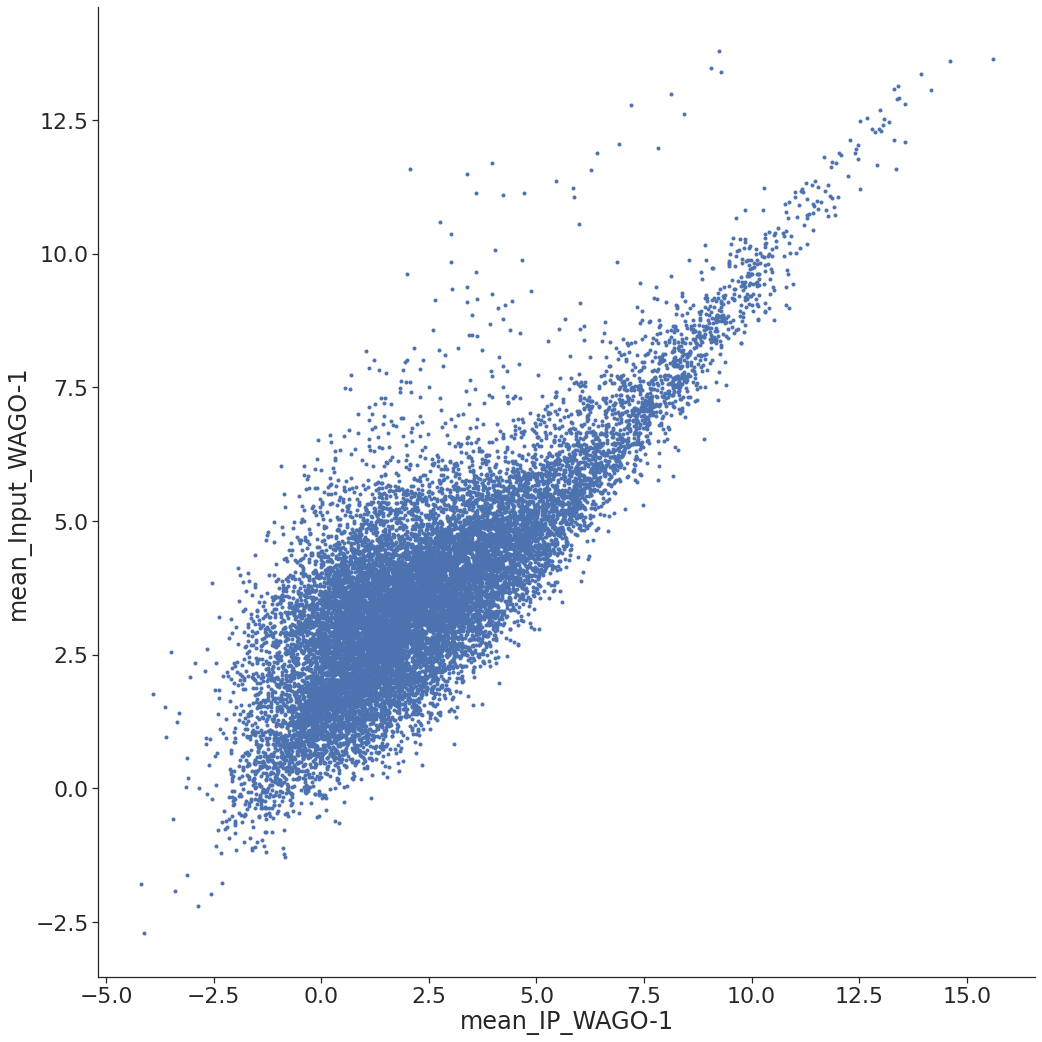

In [90]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_Input_WAGO-1",
                      data=tpm,
                      fit_reg=False,
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

In [91]:
wago_1_ip_over_input_path = "../../03_WAGO_IPs/results/filter/DE_htseq_count__1_alignment_per_read__reverse__Input_WAGO-1__IP_WAGO-1/DE_edgeR/final_table_FDR_low.tsv"

In [92]:
wago_1_ip_over_input = pd.read_csv(wago_1_ip_over_input_path, header=0, sep="\t")

In [93]:
sig_wago_1_ip_over_input = wago_1_ip_over_input[(wago_1_ip_over_input["FDR"]<0.05) &
                                                (wago_1_ip_over_input["logFC"]>0)
                                               ].id.to_list()

In [94]:
tpm["Significant"] = "No"
tpm.loc[tpm.index.isin(sig_wago_1_ip_over_input), "Significant"] = "FDR<0.05"

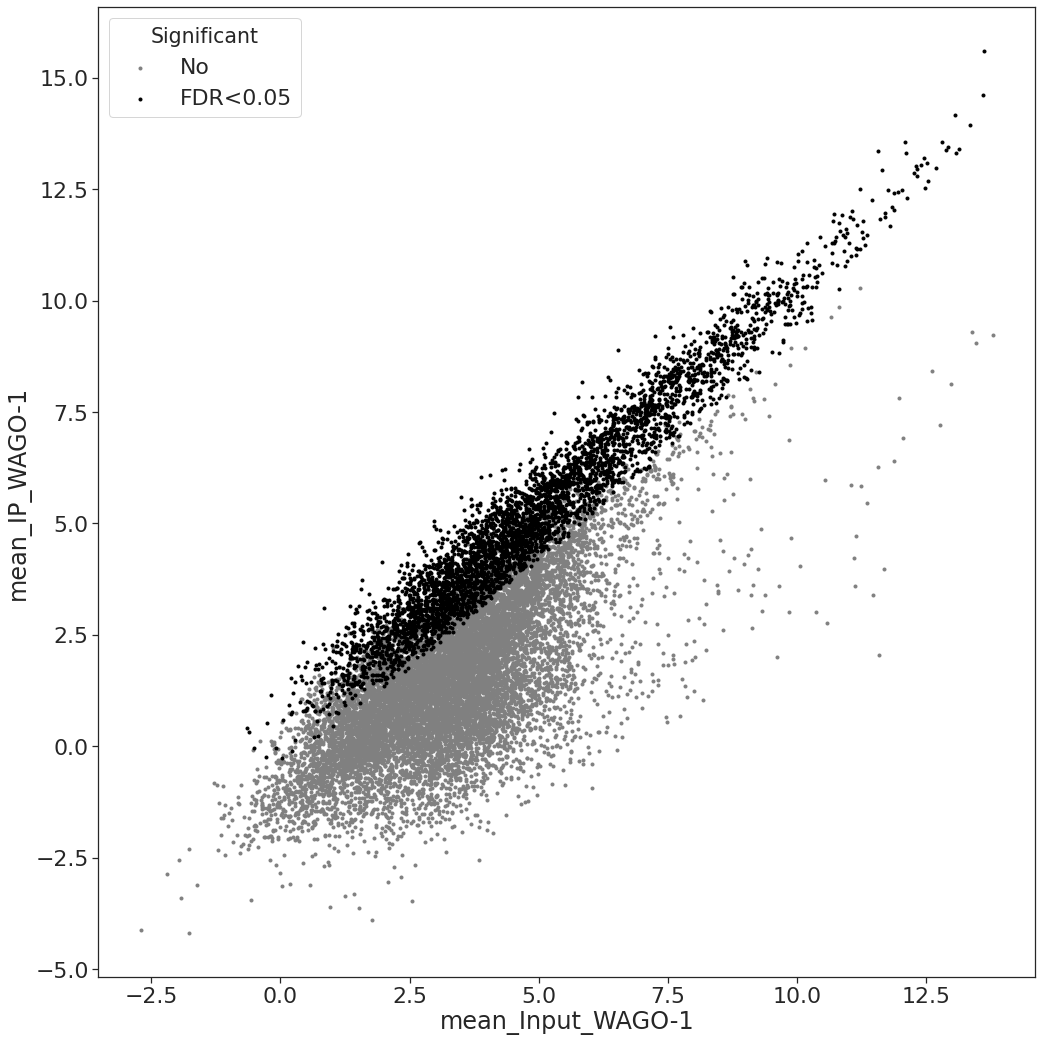

In [95]:
sns_plot = sns.lmplot(x=f"mean_Input_WAGO-1",
                      y=f"mean_IP_WAGO-1",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "FDR<0.05"],
                      palette=["grey", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)
plt.savefig("scatterplot_mean_Input_WAGO-1_mean_IP_WAGO-1_mark_significant_IP_ALT_5BC.pdf")

In [96]:
tpm["Significant"].value_counts()

No          12358
FDR<0.05     4151
Name: Significant, dtype: int64

In [97]:
tpm.loc[tpm.index.isin(df_csr_1_IP_over_input[(df_csr_1_IP_over_input["FDR"]<0.05) & (df_csr_1_IP_over_input["logFC"]>0)]["id"].values.tolist()), "Significant"] = "csr-1 bound"

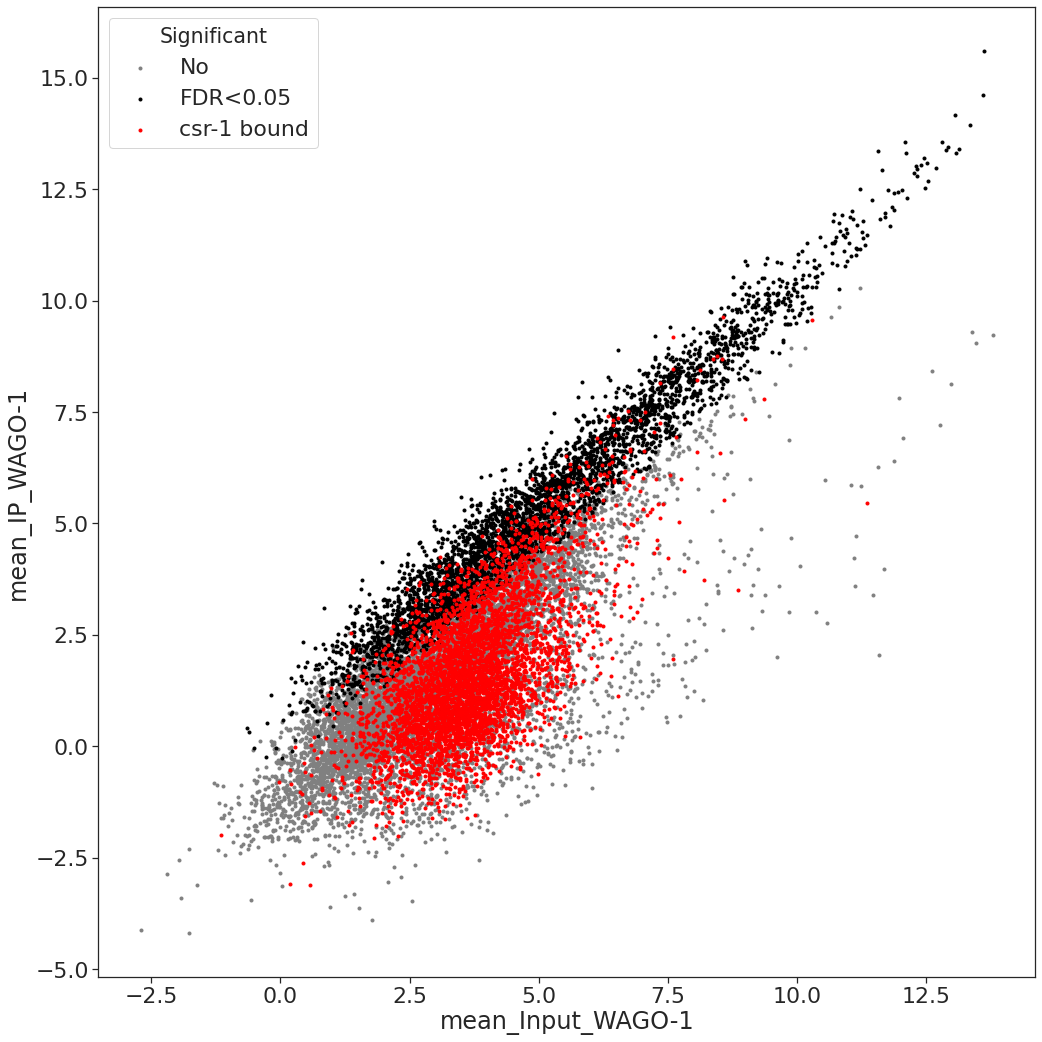

In [98]:
sns_plot = sns.lmplot(x=f"mean_Input_WAGO-1",
                      y=f"mean_IP_WAGO-1",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "FDR<0.05", "csr-1 bound"],
                      palette=["grey", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)
plt.savefig("scatterplot_mean_Input_WAGO-1_mean_IP_WAGO-1_mark_significant_IP_mark_csr-1_ALT_5BC.pdf")

In [99]:
tpm["Significant"].value_counts()

No             8343
csr-1 bound    4568
FDR<0.05       3598
Name: Significant, dtype: int64

# Correlation WAGO-1_dpf3-null IP over WAGO-1_dpf3-null Input (Mark csr-1 bound)

In [100]:
df.columns

Index(['Name', 'length', 'counts_Input_WAGO-1_A', 'counts_Input_WAGO-1_B',
       'counts_Input_WAGO-1_C', 'counts_Input_WAGO-1_dpf-3_null_A',
       'counts_Input_WAGO-1_dpf-3_null_B', 'counts_Input_WAGO-1_dpf-3_null_C',
       'counts_Input_WAGO-1_P3G_A', 'counts_Input_WAGO-1_P3G_B',
       'counts_Input_WAGO-1_P3G_C', 'counts_Input_WAGO-3_A',
       'counts_Input_WAGO-3_B', 'counts_Input_WAGO-3_C',
       'counts_Input_WAGO-3_dpf-3_null_A', 'counts_Input_WAGO-3_dpf-3_null_B',
       'counts_Input_WAGO-3_dpf-3_null_C', 'counts_Input_WAGO-4_A',
       'counts_Input_WAGO-4_B', 'counts_Input_WAGO-4_C',
       'counts_Input_WAGO-4_dpf-3_null_A', 'counts_Input_WAGO-4_dpf-3_null_B',
       'counts_Input_WAGO-4_dpf-3_null_C', 'counts_IP_WAGO-1_A',
       'counts_IP_WAGO-1_B', 'counts_IP_WAGO-1_C',
       'counts_IP_WAGO-1_dpf-3_null_A', 'counts_IP_WAGO-1_dpf-3_null_B',
       'counts_IP_WAGO-1_dpf-3_null_C', 'counts_IP_WAGO-1_P3G_A',
       'counts_IP_WAGO-1_P3G_B', 'counts_IP_WAGO-1_P3G_C'

In [101]:
df_short = df[["Name", 
              "length", 
              "counts_IP_WAGO-1_dpf-3_null_A", 
              "counts_IP_WAGO-1_dpf-3_null_B", 
              "counts_IP_WAGO-1_dpf-3_null_C",
              "counts_Input_WAGO-1_dpf-3_null_A",
              "counts_Input_WAGO-1_dpf-3_null_B",
              "counts_Input_WAGO-1_dpf-3_null_C"
             ]].copy()

In [102]:
df_short = df_short[df_short.iloc[:,2:].sum(axis=1)>10]

In [103]:
# add pseudocount
df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1

In [104]:
sample_reads = df_short.iloc[:,2:].copy()
gene_len = df_short.loc[:, ['length']]
rate = sample_reads.values / gene_len.values
tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)

In [105]:
new_columns = []
for name in list(tpm.columns):
    new_columns.append(name.replace("counts_",""))

In [106]:
tpm.columns = new_columns

In [107]:
tpm.head()

,IP_WAGO-1_dpf-3_null_A,IP_WAGO-1_dpf-3_null_B,IP_WAGO-1_dpf-3_null_C,Input_WAGO-1_dpf-3_null_A,Input_WAGO-1_dpf-3_null_B,Input_WAGO-1_dpf-3_null_C
Name,,,,,,
I:1012042-1012183:+,6.730619,7.508475,3.541271,47.997674,58.663357,45.770399
I:10128135-10128392:+,4.939265,10.744685,5.847214,26.417325,64.575169,25.191460
I:10137068-10137842:+,2.671983,1.375746,4.109397,8.794413,10.748641,8.386318
I:10140918-10141424:-,1.256736,3.785337,0.991835,13.443136,16.430368,12.819323
I:1015399-1015631:-,3.418268,6.406372,6.474598,29.251802,35.751917,55.788813


In [108]:
tpm = np.log2(tpm)

In [109]:
tpm["mean_IP_WAGO-1_dpf-3_null"] = tpm[["IP_WAGO-1_dpf-3_null_A", 
                             "IP_WAGO-1_dpf-3_null_B", 
                             "IP_WAGO-1_dpf-3_null_C"]].mean(axis=1)

tpm["mean_Input_WAGO-1_dpf-3_null"] = tpm[["Input_WAGO-1_dpf-3_null_A", 
                                           "Input_WAGO-1_dpf-3_null_B", 
                                           "Input_WAGO-1_dpf-3_null_C"]].mean(axis=1)

In [110]:
wago_1_dpf_3_null_ip_over_input_path = "../../03_WAGO_IPs/results/filter/DE_htseq_count__1_alignment_per_read__reverse__Input_WAGO-1_dpf-3_null__IP_WAGO-1_dpf-3_null/DE_edgeR/final_table_FDR_low.tsv"

In [111]:
wago_1_dpf_3_null_ip_over_input = pd.read_csv(wago_1_dpf_3_null_ip_over_input_path, header=0, sep="\t")

In [112]:
sig_wago_1_dpf_3_null_ip_over_input = wago_1_dpf_3_null_ip_over_input[(wago_1_dpf_3_null_ip_over_input["FDR"]<0.05) &
                                                                      (wago_1_dpf_3_null_ip_over_input["logFC"]>0)
                                                                      ].id.to_list()

In [113]:
tpm["Significant"] = "No"
tpm.loc[tpm.index.isin(sig_wago_1_dpf_3_null_ip_over_input), "Significant"] = "FDR<0.05"

In [114]:
tpm["Significant"].value_counts()

No          13325
FDR<0.05     4715
Name: Significant, dtype: int64

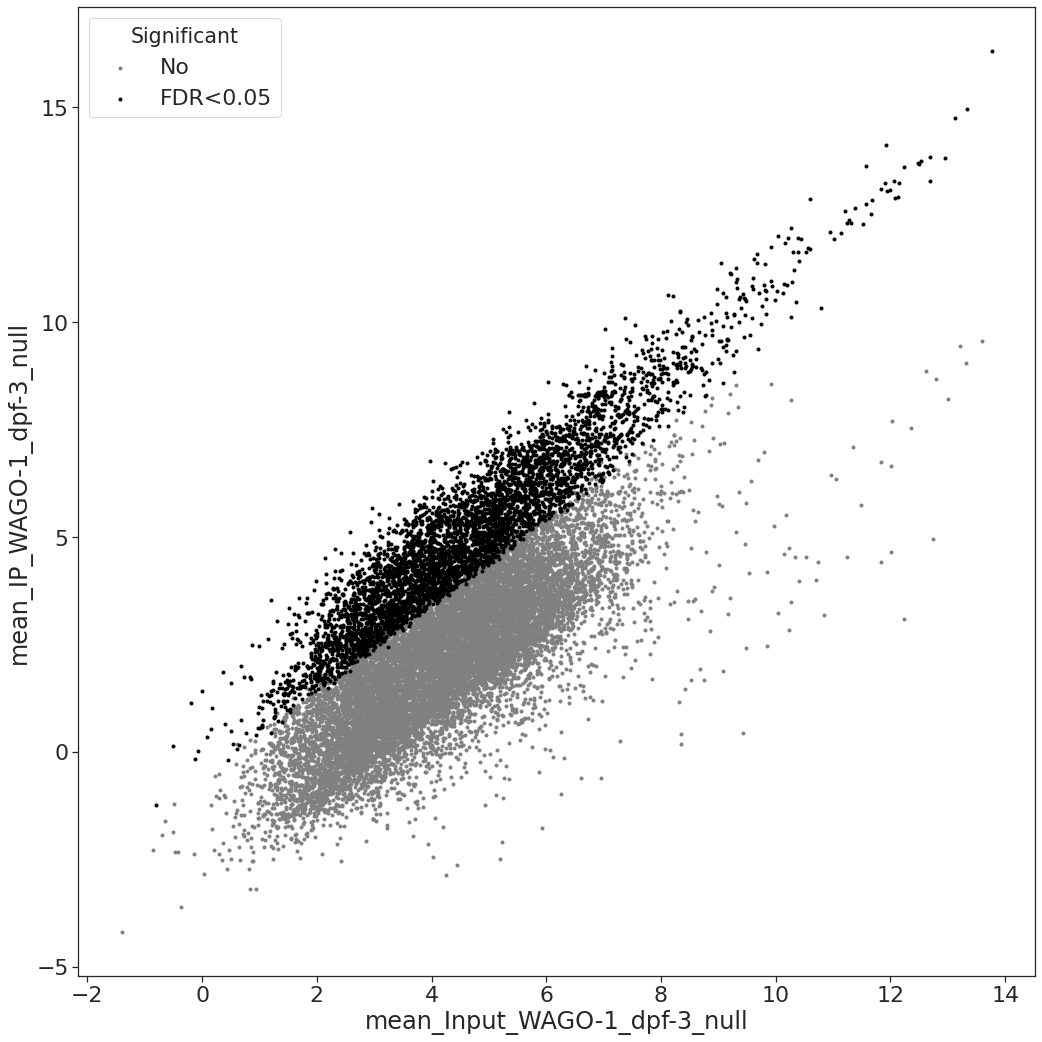

In [115]:
sns_plot = sns.lmplot(x=f"mean_Input_WAGO-1_dpf-3_null",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "FDR<0.05"],
                      palette=["grey", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)
plt.savefig("scatterplot_mean_Input_WAGO-1_dpf-3_null_mean_IP_WAGO-1_dpf-3_null_mark_significant_IP_ALT_5BC.pdf")

In [116]:
tpm.loc[tpm.index.isin(df_csr_1_IP_over_input[(df_csr_1_IP_over_input["FDR"]<0.05) & (df_csr_1_IP_over_input["logFC"]>0)]["id"].values.tolist()), "Significant"] = "csr-1 bound"

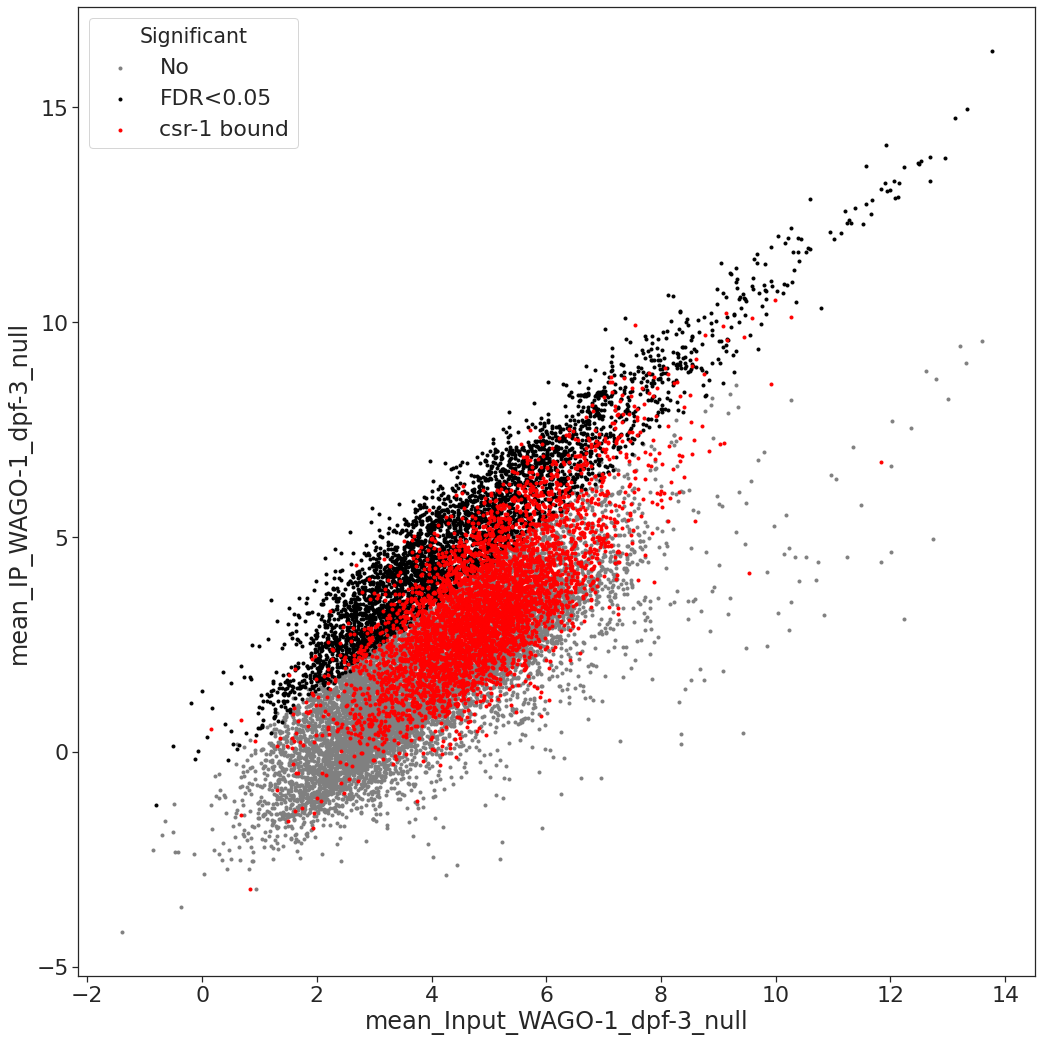

In [117]:
sns_plot = sns.lmplot(x=f"mean_Input_WAGO-1_dpf-3_null",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No", "FDR<0.05", "csr-1 bound"],
                      palette=["grey", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)
plt.savefig("scatterplot_mean_Input_WAGO-1_dpf-3_null_mean_IP_WAGO-1_dpf-3_null_mark_significant_IP_mark_csr-1_ALT_5BC.pdf")

In [118]:
tpm["Significant"].value_counts()

No             9525
csr-1 bound    4656
FDR<0.05       3859
Name: Significant, dtype: int64

# Correlate 3135 and 3134 only inputs

In [120]:
counts = pd.read_csv("../../04_csr1_ip_and_wago_double_mutants/results/counts/1_alignment_per_read_reverse/counts.tsv",
                     header=0,
                     sep="\t")

In [122]:
counts.shape

(75398, 31)

In [121]:
counts.head()

,Name,counts_HW3115_Replicate_A_INPUT,counts_HW3115_Replicate_B_INPUT,counts_HW3115_Replicate_C_INPUT,counts_HW3128_Replicate_A_INPUT,counts_HW3128_Replicate_B_INPUT,counts_HW3128_Replicate_C_INPUT,counts_HW3134_Replicate_A_INPUT,counts_HW3134_Replicate_B_INPUT,counts_HW3134_Replicate_C_INPUT,...,counts_HW3134_Replicate_C_IP,counts_HW3135_Replicate_A_IP,counts_HW3135_Replicate_B_IP,counts_HW3135_Replicate_C_IP,counts_Input_WAGO-1_A,counts_Input_WAGO-1_B,counts_Input_WAGO-1_C,counts_IP_WAGO-1_A,counts_IP_WAGO-1_B,counts_IP_WAGO-1_C
0,I:10005952-10006427:+,0,0,0,0,0,0,1,0,2,...,9,5,4,6,0,0,0,1,2,1
1,I:10006437-10006683:+,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,I:1001335-1001573:-,0,0,0,0,0,0,0,0,1,...,2,6,4,5,0,0,0,0,1,1
3,I:10015772-10015842:+,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,I:1002040-1002265:-,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [123]:
df = pd.merge(gene_length, counts, on="Name")

In [124]:
for i in df.iloc[:,2:].values:
    print(len(i))
    break

30


In [125]:
df.columns

Index(['Name', 'length', 'counts_HW3115_Replicate_A_INPUT',
       'counts_HW3115_Replicate_B_INPUT', 'counts_HW3115_Replicate_C_INPUT',
       'counts_HW3128_Replicate_A_INPUT', 'counts_HW3128_Replicate_B_INPUT',
       'counts_HW3128_Replicate_C_INPUT', 'counts_HW3134_Replicate_A_INPUT',
       'counts_HW3134_Replicate_B_INPUT', 'counts_HW3134_Replicate_C_INPUT',
       'counts_HW3135_Replicate_A_INPUT', 'counts_HW3135_Replicate_B_INPUT',
       'counts_HW3135_Replicate_C_INPUT', 'counts_HW3115_Replicate_A_IP',
       'counts_HW3115_Replicate_B_IP', 'counts_HW3115_Replicate_C_IP',
       'counts_HW3128_Replicate_A_IP', 'counts_HW3128_Replicate_B_IP',
       'counts_HW3128_Replicate_C_IP', 'counts_HW3134_Replicate_A_IP',
       'counts_HW3134_Replicate_B_IP', 'counts_HW3134_Replicate_C_IP',
       'counts_HW3135_Replicate_A_IP', 'counts_HW3135_Replicate_B_IP',
       'counts_HW3135_Replicate_C_IP', 'counts_Input_WAGO-1_A',
       'counts_Input_WAGO-1_B', 'counts_Input_WAGO-1_C', 'coun

In [126]:
df_short = df[["Name", 
              "length", 
              "counts_HW3135_Replicate_A_INPUT", 
              "counts_HW3135_Replicate_B_INPUT", 
              "counts_HW3135_Replicate_C_INPUT",
              "counts_HW3134_Replicate_A_INPUT", 
              "counts_HW3134_Replicate_B_INPUT", 
              "counts_HW3134_Replicate_C_INPUT",
             ]].copy()

In [127]:
df_short = df_short[df_short.iloc[:,2:].sum(axis=1)>10]

In [128]:
# add pseudocount
df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1

In [129]:
sample_reads = df_short.iloc[:,2:].copy()
gene_len = df_short.loc[:, ['length']]
rate = sample_reads.values / gene_len.values
tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)

In [130]:
tpm = np.log2(tpm)

In [132]:
new_columns = []
for name in list(tpm.columns):
    new_columns.append(name.replace("counts_",""))

In [133]:
tpm.columns = new_columns

In [134]:
tpm.shape

(11183, 6)

In [135]:
tpm.head()

,HW3135_Replicate_A_INPUT,HW3135_Replicate_B_INPUT,HW3135_Replicate_C_INPUT,HW3134_Replicate_A_INPUT,HW3134_Replicate_B_INPUT,HW3134_Replicate_C_INPUT
Name,,,,,,
I:10238747-10239295:+,4.364439,4.705625,3.915991,4.098680,2.760356,4.551116
I:10239328-10241663:+,7.532664,7.454406,7.219146,7.659133,7.751567,7.789880
I:1048801-1048973:+,6.030473,6.049731,5.582025,6.442786,5.648782,5.217150
I:10528240-10529850:-,4.618715,3.830619,3.947875,5.649938,5.851133,5.698477
I:10697144-10697466:+,4.129711,4.733932,3.096300,4.863952,4.748020,2.731425


In [136]:
tpm["mean_INPUT_HW3135"] = tpm[["HW3135_Replicate_A_INPUT", "HW3135_Replicate_B_INPUT", "HW3135_Replicate_C_INPUT"]].mean(axis=1)
tpm["mean_INPUT_HW3134"] = tpm[["HW3134_Replicate_A_INPUT", "HW3134_Replicate_B_INPUT", "HW3134_Replicate_C_INPUT"]].mean(axis=1)

In [137]:
tpm.head()

,HW3135_Replicate_A_INPUT,HW3135_Replicate_B_INPUT,HW3135_Replicate_C_INPUT,HW3134_Replicate_A_INPUT,HW3134_Replicate_B_INPUT,HW3134_Replicate_C_INPUT,mean_INPUT_HW3135,mean_INPUT_HW3134
Name,,,,,,,,
I:10238747-10239295:+,4.364439,4.705625,3.915991,4.098680,2.760356,4.551116,4.328685,3.803384
I:10239328-10241663:+,7.532664,7.454406,7.219146,7.659133,7.751567,7.789880,7.402072,7.733527
I:1048801-1048973:+,6.030473,6.049731,5.582025,6.442786,5.648782,5.217150,5.887410,5.769573
I:10528240-10529850:-,4.618715,3.830619,3.947875,5.649938,5.851133,5.698477,4.132403,5.733183
I:10697144-10697466:+,4.129711,4.733932,3.096300,4.863952,4.748020,2.731425,3.986647,4.114466


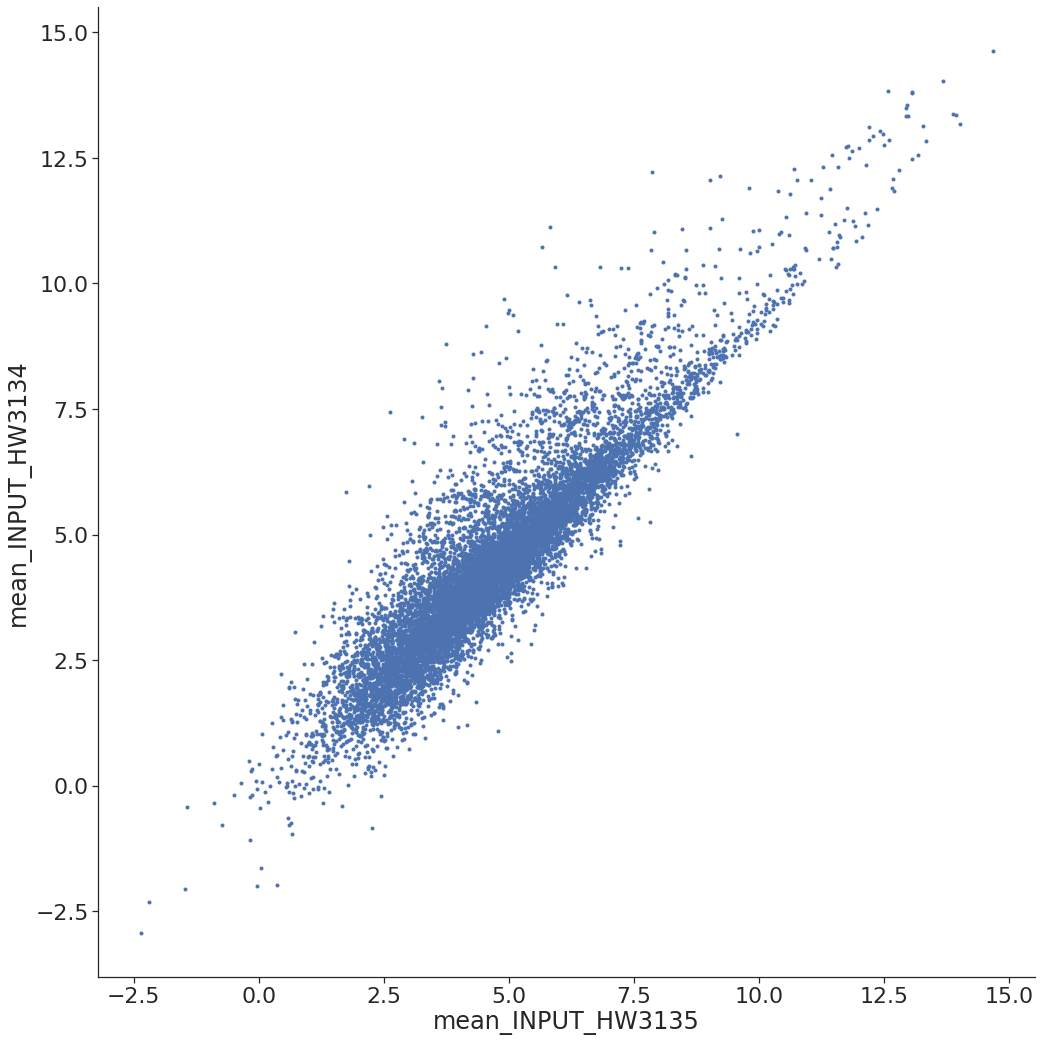

In [138]:
sns_plot = sns.lmplot(x=f"mean_INPUT_HW3135",
                      y=f"mean_INPUT_HW3134",
                      data=tpm,
                      fit_reg=False,
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

In [150]:
#### paths for DE
de_3135_Input_over_WAGO_1_Input_path = "../../04_csr1_ip_and_wago_double_mutants/results/filter/DE_htseq_count__1_alignment_per_read__reverse__Input_WAGO-1__HW3135_INPUT/DE_edgeR/final_table_FDR_low_with_gene_info.tsv"

In [151]:
de_3135_Input_over_WAGO_1_Input = pd.read_csv(de_3135_Input_over_WAGO_1_Input_path, header=0, sep="\t")

In [153]:
de_3135_Input_over_WAGO_1_Input.shape

(2749, 14)

In [173]:
de_3135_Input_over_WAGO_1_Input_all_sig_down = de_3135_Input_over_WAGO_1_Input[de_3135_Input_over_WAGO_1_Input["logFC"]<0].id.to_list()

In [174]:
len(de_3135_Input_over_WAGO_1_Input_all_sig_down)

1434

In [175]:
tpm["Significant"] = "No"
tpm.loc[tpm.index.isin(de_3135_Input_over_WAGO_1_Input_all_sig), "Significant"] = "3135_Input_over_WAGO_1_Input"

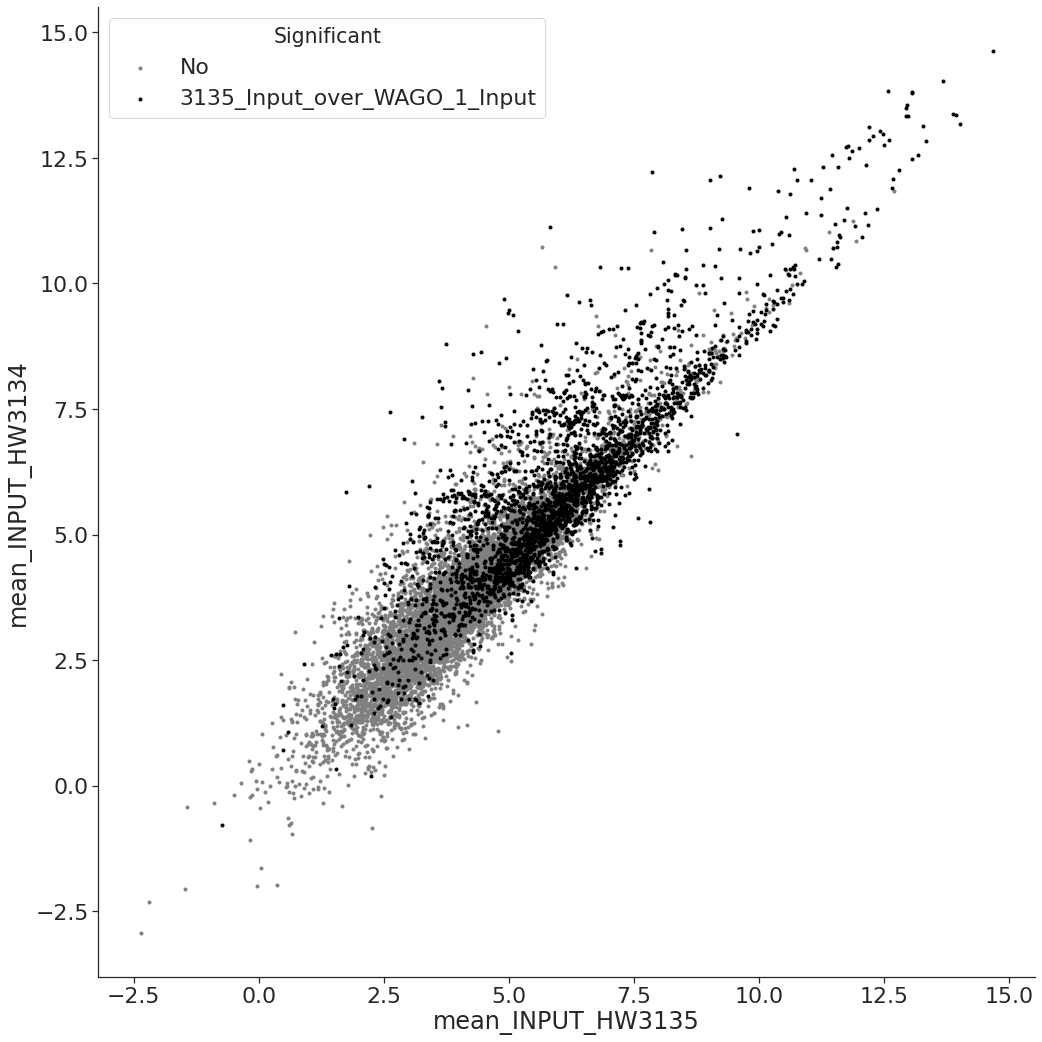

In [177]:
sns_plot = sns.lmplot(x=f"mean_INPUT_HW3135",
                      y=f"mean_INPUT_HW3134",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
                      hue_order=["No",  "3135_Input_over_WAGO_1_Input"],
                      palette=["grey", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)